In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.special import gamma
from scipy.interpolate import splrep, BSpline

import pitszi

beamFWHM = 18.0
nomask = True

# Model

In [2]:
c = pitszi.Model(RA=10*u.deg, Dec=10*u.deg, redshift=0.5, M500=1e15*u.Msun, silent=False)
c.set_pressure_profile_universal_param('P13UPP')

c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'Norm': 0.5, 
                                'slope': -11/3.0,
                                'Linj': 100*u.Mpc,
                                'Ldis': 30*u.kpc}

c.triaxiality = {'min_to_maj_axis_ratio':1, 'int_to_maj_axis_ratio':1,
                 'euler_angle1':0*u.deg, 'euler_angle2':0*u.deg, 'euler_angle3':0*u.deg}
        
c.map_coord  = SkyCoord(10*u.deg, 10*u.deg, frame="icrs")
c.map_fov   = [5, 5]*u.arcmin
c.map_reso  = 5*u.arcsec
c.los_reso  = 10*u.kpc
c.R_truncation = c.R500*3

print('20 arcsec in kpc: ', (c.D_ang*(20*u.arcsec).to_value('rad')).to('kpc'))

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.
Setting gNFW Planck coll. (2013) UPP.
Setting model_pressure_fluctuation value
Fixing: R500 if involved
Setting the map coordinates
Setting: map_header to None, as map properties are now set by hand
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting the l.o.s. resolution value
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
20 arcsec in kpc:  125.76462897253

# Analysis

In [3]:
compton = c.get_sz_map(force_isotropy=False)
c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'Norm': 0.0, 'slope': -11/3.,'Linj': 1*u.Mpc,'Ldis': 10*u.kpc}
compton_sph = c.get_sz_map()

----- INFO: isotropy and k=0 mode.
            Modes with k=0 are set to 0.
            The maximum sampling k for having isotropy is  0.015633184870640738  kpc^-1
            This corresponds to a Nyquist sampling resolution  31.98324616112002  kpc
----- INFO: fluctuation cube rms.
            Expected rms over the full k range: 0.5
            Expected rms given the missing k range: 0.19367423885788596
            Actual rms for this noise realization: 0.1736361240573375
Setting model_pressure_fluctuation value
Fixing: R500 if involved


In [4]:
karcsec = np.linspace(0, 1/beamFWHM*10, 1000)
kfov = 1/(5*60)
TF = {'k':karcsec*u.arcsec**-1, 'TF':1-np.exp(-karcsec/kfov)}

compton_filt = pitszi.utils.apply_transfer_function(compton, c.map_reso.to_value('arcsec'), 
                                                    beamFWHM, TF, apps_TF_LS=False)
compton_sph_filt = pitszi.utils.apply_transfer_function(compton_sph, c.map_reso.to_value('arcsec'), 
                                                        beamFWHM, TF, apps_TF_LS=False)

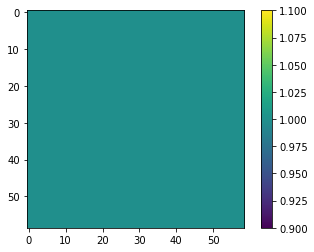

In [5]:
if nomask is True:
    mask = compton*0 + 1
else:
    mask = compton*0 + 1
    mask[compton < np.amax(compton)*0.1] = 0
plt.imshow(mask)
plt.colorbar()

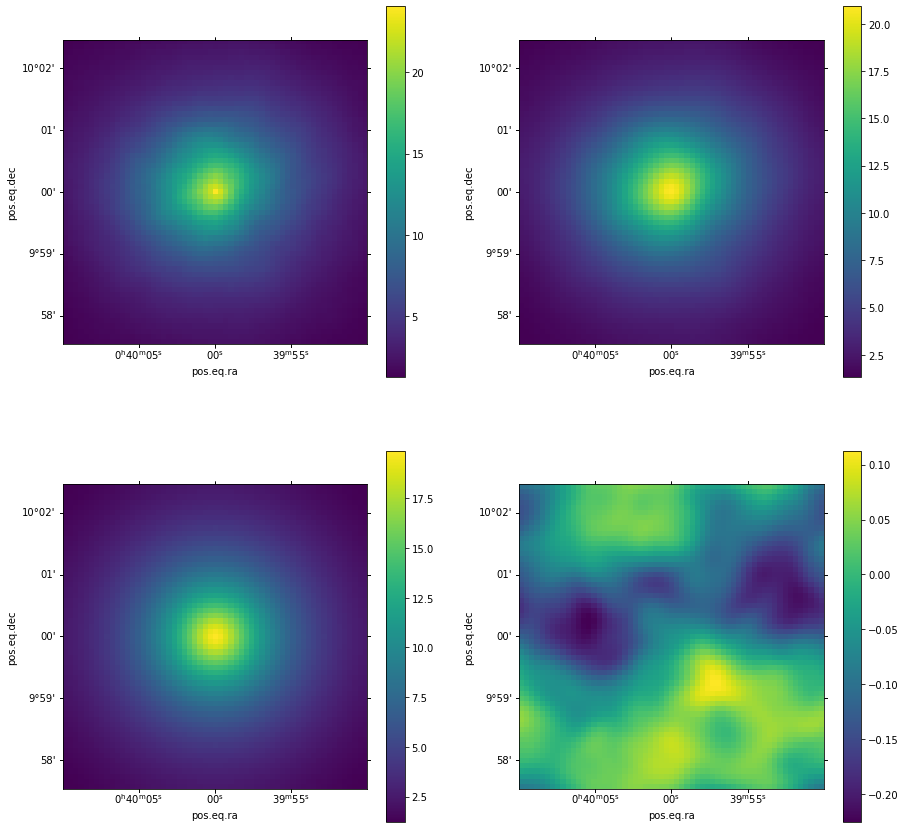

In [6]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2, 2, 1, projection=WCS(c.get_map_header()))
plt.imshow(compton*1e5*mask)
plt.colorbar()

ax = plt.subplot(2, 2, 2, projection=WCS(c.get_map_header()))
plt.imshow(compton_filt*1e5*mask)
plt.colorbar()

ax = plt.subplot(2, 2, 3, projection=WCS(c.get_map_header()))
plt.imshow(compton_sph_filt*1e5*mask)
plt.colorbar()

ax = plt.subplot(2, 2, 4, projection=WCS(c.get_map_header()))
plt.imshow((compton_sph_filt-compton_filt)/compton_sph_filt*mask)
plt.colorbar()

In [7]:
image_true = (compton_filt-compton_sph_filt)/compton_sph_filt
image_mask = (compton_filt-compton_sph_filt)/compton_sph_filt * mask

In [8]:
k2d, pk2d = pitszi.utils.get_pk2d(image_true, c.map_reso.to_value('arcsec'), Nbin=100, 
                                  scalebin='lin', 
                                  kmin=1/np.amin(c.map_fov.to_value('arcsec')), 
                                  kmax=1/c.map_reso.to_value('arcsec'))

In [9]:
epsilon = 1e-3
sigma2fwhm = 2 * np.sqrt(2*np.log(2))
sigma_list = 1 / (k2d * np.sqrt(2 * np.pi**2))
spec=[]
method = 1

for sigma in sigma_list:
    k_i = 1 / (sigma * np.sqrt(2 * np.pi**2))
    sigma1 = sigma / np.sqrt(1+epsilon)
    sigma2 = sigma * np.sqrt(1+epsilon)
    if method==1:
        img_conv1 = pitszi.utils.apply_transfer_function(image_mask, c.map_reso.to_value('arcsec'), sigma2fwhm*sigma1, 0, apps_TF_LS=False)
        img_conv2 = pitszi.utils.apply_transfer_function(image_mask, c.map_reso.to_value('arcsec'), sigma2fwhm*sigma2, 0, apps_TF_LS=False)     
        mask_conv1 = pitszi.utils.apply_transfer_function(mask, c.map_reso.to_value('arcsec'), sigma2fwhm*sigma1, 0, apps_TF_LS=False)
        mask_conv2 = pitszi.utils.apply_transfer_function(mask, c.map_reso.to_value('arcsec'), sigma2fwhm*sigma2, 0, apps_TF_LS=False)     
    if method == 2:
        img_conv1 = gaussian_filter(image_mask, sigma1/c.map_reso.to_value('arcsec'))
        img_conv2 = gaussian_filter(image_mask, sigma2/c.map_reso.to_value('arcsec'))     
        mask_conv1 = gaussian_filter(mask, sigma1/c.map_reso.to_value('arcsec'))
        mask_conv2 = gaussian_filter(mask, sigma2/c.map_reso.to_value('arcsec'))     
    
    img_conv = (img_conv1/mask_conv1 - img_conv2/mask_conv2) * mask
    img_conv[mask == 0] = 0
    
    var = np.sum(img_conv**2) / mask.size * (mask.size / np.sum(mask))
    spec_i = var / epsilon**2 / np.pi / k_i**2
    
    spec.append(spec_i)
spec = np.array(spec)

In [10]:
# bias from Arevalo directly
der = -np.gradient(np.log10(spec), np.log10(k2d))
bias = 2**(der/2) * gamma(3 - der/2) / gamma(3)

# bias from interpolated 'denoise' direct spectrum
tck_s = splrep(np.log10(k2d), np.log10(pk2d), s=1)
der2 = -np.gradient(BSpline(*tck_s)(np.log10(k2d)), np.log10(k2d))
bias2 = 2**(der2/2) * gamma(3 - der2/2) / gamma(3)

# bias from Romero
der = -np.gradient(np.log10(spec), np.log10(k2d))
sigma_i = beamFWHM/2.35
k_i = 1 / (np.sqrt(2) * np.pi * sigma_i)
x_i = k_i / k2d
der0 = np.mean(der[(k2d<k_i/2)*(k2d>k_i/5)])
PSFcorr = (1 + 1/x_i**2)**(3-der0/2)
bias3 = 2**(der0/2) * gamma(3 - der0/2) / gamma(3) * PSFcorr

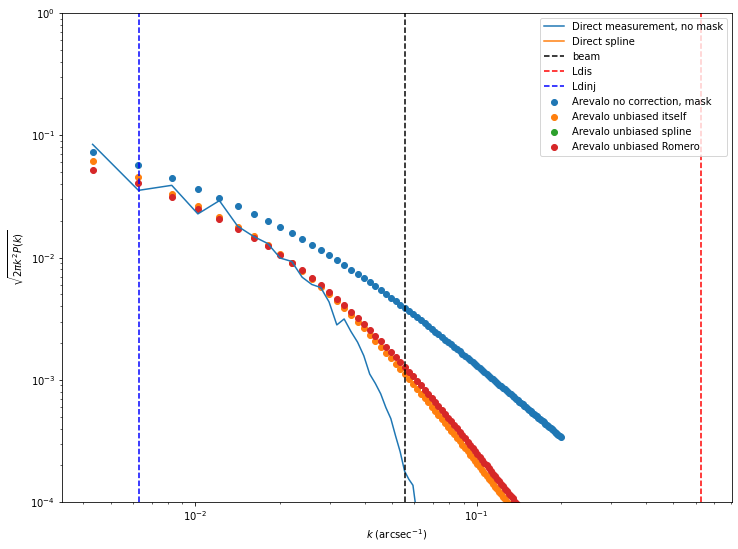

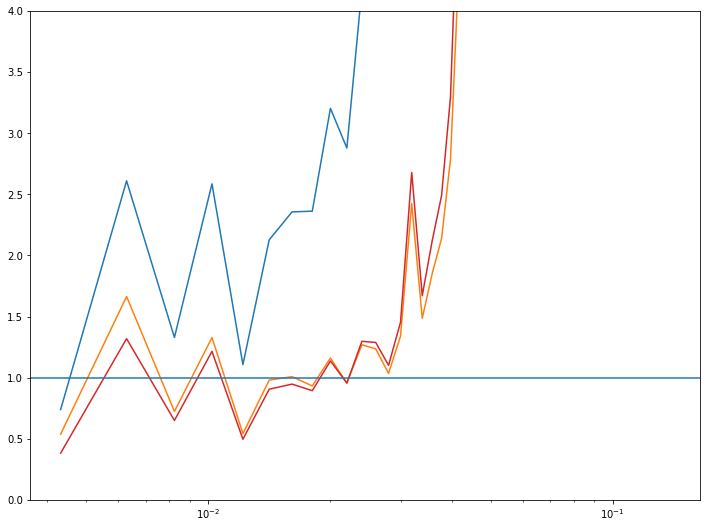

In [11]:
plt.figure(figsize=(12,9))
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d), label='Direct measurement, no mask')
plt.scatter(k2d, np.sqrt(2*np.pi*k2d**2*spec), label='Arevalo no correction, mask')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*10**BSpline(*tck_s)(np.log10(k2d))), label='Direct spline')
plt.scatter(k2d, np.sqrt(2*np.pi*k2d**2*spec/bias), label='Arevalo unbiased itself')
plt.scatter(k2d, np.sqrt(2*np.pi*k2d**2*spec/bias2), label='Arevalo unbiased spline')
plt.scatter(k2d, np.sqrt(2*np.pi*k2d**2*spec/bias3), label='Arevalo unbiased Romero')
plt.xlabel(r'$k$ (arcsec$^{-1}$)')
plt.ylabel(r'$\sqrt{2 \pi k^2 P(k)}$')
plt.axvline(1/beamFWHM, color='k', ls='--', label='beam')
plt.axvline(1/((c.model_pressure_fluctuation['Ldis']/c.D_ang).to_value('')*3600*180/np.pi), color='r', ls='--', label='Ldis')
plt.axvline(1/((c.model_pressure_fluctuation['Linj']/c.D_ang).to_value('')*3600*180/np.pi), color='b', ls='--', label='Ldinj')
plt.ylim(1e-4,1)
plt.legend()

plt.figure(figsize=(12,9))
plt.plot(k2d, spec/pk2d)
plt.plot(k2d, spec/bias/pk2d)
plt.plot(k2d, spec/bias2/pk2d)
plt.plot(k2d, spec/bias3/pk2d)
plt.axhline(1)
plt.ylim(0,4)
plt.xscale('log')